In [1]:
from netCDF4 import Dataset
from netCDFfunc.utility import get_data_sequence, get_data_A, get_data_by_date, save_img, show_img, masking, cropping

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from collections import Counter
import datetime as dt

import math
from tqdm.notebook import tqdm

In [2]:
base_dir = '/Volumes/T7/AVHRR_OI_SST/v2.1/'

In [3]:
def to_img(arr, output_path, time, lon=None, lat=None, figsize=(), save_img=False, show_img=False, is_anomaly = False, is_grade=False):
    plt.style.use('default')
    
    if figsize == ():
        x, y = arr.shape
    else :
        x,y = figsize
        
    x = x/60
    y = y/60
    
    fig, ax = plt.subplots(figsize=(24,12))
    gca_ax = plt.gca()
    
    if arr.dtype == np.float32:
        np.place(arr, arr[:,:]==-999, np.nan)
        
    if is_anomaly == True :
        cmap = cm.jet.copy()
        vmax = 10.2
        vmin = 0
        
    elif is_grade == True :
        vmax = 5
        vmin = 0
        
        grade_0 = np.array([179/256, 241/256, 255/256, 1])
        grade_1 = np.array([255/256, 255/256, 128/256, 1])
        grade_2 = np.array([255/256, 179/256, 53/256, 1])
        grade_3 = np.array([255/256, 129/256, 0/256, 1])
        grade_4 = np.array([203/256, 76/256, 1/256, 1])
        grade_5 = np.array([153/256, 26/256, 0/256, 1])
        new_cmap = np.array([grade_0, grade_1, grade_2, grade_3, grade_4, grade_5])

        if 5 not in arr :
            new_cmap = new_cmap[:-1]
            if 4 not in arr :
                new_cmap = new_cmap[:-1]
                if 3 not in arr :
                    new_cmap = new_cmap[:-1]
                    if 2 not in arr :
                        new_cmap = new_cmap[:-1]
                        if 1 not in arr :
                            new_cmap = new_cmap[:-1]

            
        cmap = ListedColormap(new_cmap)
        
    cmap.set_bad(color='gray')
    cmap.set_under(color=np.array([250/256, 250/256, 250/256, 1]))
    
        
    if type(lat) != np.ndarray or type(lon) != np.ndarray :
        if is_anomaly == True : im = plt.imshow(arr, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
        elif is_grade == True : im = plt.imshow(arr, cmap=cmap, origin='lower', vmin=vmin)#, vmax=vmax)
    else :
        im = plt.imshow(arr, cmap=cmap, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], vmin=vmin, vmax=vmax) 
    
        plt.xticks(range(0,361, 20))
        plt.yticks(range(-80,81,20))
        plt.grid(True, linestyle='--', color='black')
        
        x_labels = ['20°E','40°E','60°E','80°E','100°E','120°E','140°E','160°E','180°','160°W','140°W','120°W','100°W','80°W','60°W','40°W','20°W','0','20°E']
        y_labels = ['80°S','60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N']
        ax.set_xticklabels(x_labels)
        ax.set_yticklabels(y_labels)
    
    
    
    divider = make_axes_locatable(gca_ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    if is_anomaly == True : 
        plt.colorbar(im, cax=cax)
    
    plt.text(-30,0.9,f'{time}',{'fontsize':30}, transform=plt.gca().transAxes, va='top', ha='left')
    
    if save_img == True :
        plt.savefig(output_path, dpi=150, bbox_inches='tight')

    if show_img == True :
        plt.show()
    plt.close()

In [4]:
ds_in = get_data_by_date(base_dir=base_dir,
                         get_data_func=get_data_A,
                         var_name='sst',
                         start_date=(1991,1,1),
                         end_date=(2020,12,31))

  0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
ds_ice = get_data_by_date(base_dir=base_dir,
                          get_data_func=get_data_A,
                          var_name='ice',
                          start_date=(1991,1,1),
                          end_date=(2020,12,31),
                          is_mask=True)

  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
ds_sst = get_data_by_date(base_dir=base_dir,
                            get_data_func=get_data_A,
                            var_name='sst',
                            start_date=(2020,1,1),
                            end_date=(2020,12,31))

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
days = [31,28,31,30,31,30,31,31,30,31,30,31]
anomaly_chk = []
heat_level_chk = []
for month, day_len in tqdm(zip(range(1,13), days)):
    for day in range(1,day_len+1):
        pctl = np.percentile(ds_in[(month, day)], 90, axis=0)
        pctl = cropping(pctl, 'rok')
        np.place(pctl, pctl[:,:]==-999, np.nan)
        
        mean = np.mean(ds_in[(month, day)], axis=0)
        mean = cropping(mean, 'rok')
        np.place(mean, mean[:,:]==-999, np.nan)
        
        sst = ds_sst[(month, day)][0]
        sst = cropping(sst, 'rok')
        
        ice_accum = np.sum(ds_ice[(month, day)], axis=0)
        np.place(ice_accum, ice_accum[:,:] <= 30 * 0.15, False)
        np.place(ice_accum, ice_accum[:,:] > 30 * 0.15, True)
        ice_accum = ice_accum.astype(bool)
        ice_accum = cropping(ice_accum, 'rok')
        
        anomaly = sst - mean
        np.place(anomaly, anomaly[:,:]<0, 0)
        anomaly = masking(anomaly, np.invert(ice_accum), fill_value=-1)
        anomaly_chk.append(anomaly)
        
        diff = pctl - mean
        
        heat_level = np.ceil(anomaly / diff)
        heat_level = masking(heat_level, np.invert(ice_accum), fill_value=-1)
        heat_level_chk.append(heat_level)
        np.place(heat_level, heat_level[:,:]>5, 5)
        
        date = dt.date(1000, month,day).strftime('%m%d')
        
        save_img(anomaly, f'/Volumes/T7/intermediate_output/rok_anomaly_heatlevel_criteria_change_2/anomaly_{date}', date)
        save_img(heat_level, f'/Volumes/T7/intermediate_output/rok_anomaly_heatlevel_criteria_change_2/heat_level_{date}', date, is_grade=True)

0it [00:00, ?it/s]

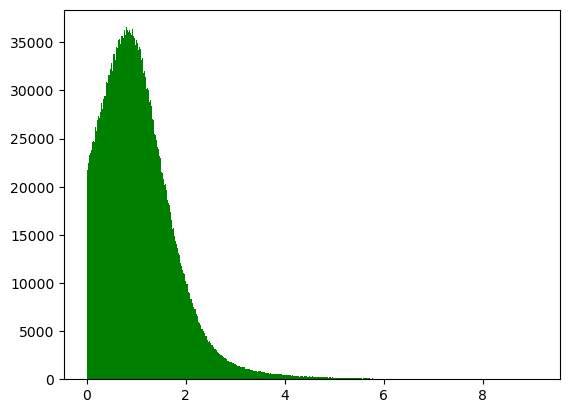

In [8]:
anomaly_dist = np.array(anomaly_chk).flatten()
np.place(anomaly_dist, anomaly_dist <= 0, np.nan)

plt.hist(anomaly_dist, bins=500, color='green')
plt.show()

In [9]:
print(f'''
min : {np.nanmin(anomaly_dist)}
max : {np.nanmax(anomaly_dist)}
mean : {np.nanmean(anomaly_dist)}
med : {np.nanmedian(anomaly_dist)}
''')


min : 2.384185791015625e-07
max : 9.108997344970703
mean : 1.0773943662643433
med : 0.961319088935852



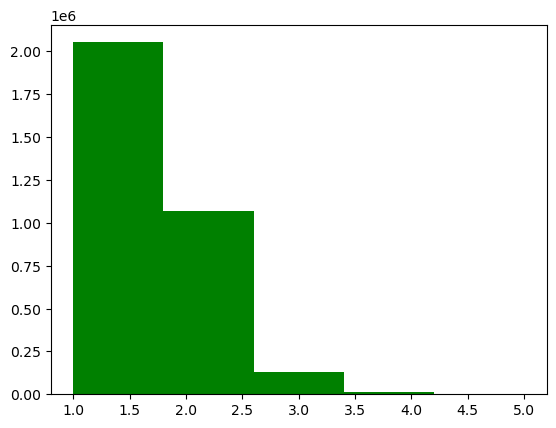

In [10]:
heat_level_dist = np.array(heat_level_chk).flatten()
np.place(heat_level_dist, heat_level_dist <= 0, np.nan)

plt.hist(heat_level_dist, bins=5, color='green')
plt.show()

In [11]:
np.unique(heat_level_dist)

array([ 1.,  2.,  3.,  4.,  5., nan])